In [1]:
import pandas as pd

# 파일 경로
file_path = "C:/Users/cysy0/Desktop/programmers/work/a_final_project/hits/hits_preprocessing_compressed.csv"

df = pd.read_csv(file_path)

# 1. 전처리

## 1.1 사용 컬럼 확인

In [ ]:
df.info()

In [ ]:
for col in df.columns:
    print(col)
    print(df[col].value_counts().head(10))  # 상위 10개 빈도 값 출력
    print(df[col].dtype)                    # 데이터 타입 
    print('------------------')

## 1.2 변수 제거 및 인코딩

- 불필요한 컬럼 제거 (타겟 예측 정보 포함 변수, 타 컬럼 정보 포함 변수 등)
- Frequency Encoding (히트 단위 별 경로를 나타내는 변수)
- One - Hot Encoding (범주형 변수 전체 or 상위 10-5 카테고리 )

In [2]:
import pandas as pd

# 1. 타겟 변수 생성: action_group (0 또는 1)
df['action_group'] = df['maxActionType'].apply(lambda x: 0 if x == 0 else 1)

# 2. 날짜 기반 파생 컬럼 생성 (정수형 yyyyMM 형태로 바로 생성)
df['year_month'] = df['dates'].astype(str).str[:6].astype(int)
 
# 3. 불필요한 컬럼 제거
drop_columns = [
    'session', 'converted', 'dates', 'visitStartTime',
    'transactionRevenue', 'transactions', 'bounces', 'totalTransactionRevenue',
    'isMobile', 'continent', 'longitude', 'latitude',
    'pagePathFlow', 'typeFlow', 'pageTitlePath', 'eventActionPath',
    'eventLabelPath', 'actionTypePath', 'maxActionType', 'contentGroupPath'
]
df.drop(columns=drop_columns, inplace=True)

# 4-1. Frequency Encoding
freq_cols = ['hitTimeFlow', 'hitTimeSpentPath', 'productSummaryPath', 'promotionSummaryPath']
for col in freq_cols:
    freq_map = df[col].value_counts().to_dict()
    df[col + '_freq'] = df[col].map(freq_map)
    df.drop(columns=[col], inplace=True)

# 4-2. One-Hot Encoding - 전체 카테고리
full_ohe_cols = ['channelGrouping', 'medium', 'deviceCategory', 'socialNetwork','year_month']
df = pd.get_dummies(df, columns=full_ohe_cols, prefix=full_ohe_cols)

# 4-3. One-Hot Encoding - 상위 10개 + 기타(other)
top10_ohe_cols = ['referralPath', 'browser', 'operatingSystem', 'city', 'region', 'country', 'subContinent']
for col in top10_ohe_cols:
    top10 = df[col].value_counts().nlargest(10).index
    df[col] = df[col].apply(lambda x: x if x in top10 else '(Other)')
df = pd.get_dummies(df, columns=top10_ohe_cols, prefix=top10_ohe_cols)

# 4-4. One-Hot Encoding - 상위 5개 + 기타(other)
top5_ohe_cols = ['campaign']
for col in top5_ohe_cols:
    top5 = df[col].value_counts().nlargest(5).index
    df[col] = df[col].apply(lambda x: x if x in top5 else '(Other)')
df = pd.get_dummies(df, columns=top5_ohe_cols, prefix=top5_ohe_cols)

# 5. 전처리 완료 후 info 출력
print("✅ 전처리 완료!")
print(f"사용 컬럼 수: {df.shape[1]}")
print("컬럼 목록:")
print(df.columns.tolist())


✅ 전처리 완료!
사용 컬럼 수: 140
컬럼 목록:
['visitNumber', 'hits', 'pageviews', 'timeOnSite', 'newVisits', 'action_group', 'hitTimeFlow_freq', 'hitTimeSpentPath_freq', 'productSummaryPath_freq', 'promotionSummaryPath_freq', 'channelGrouping_(Other)', 'channelGrouping_Affiliates', 'channelGrouping_Direct', 'channelGrouping_Display', 'channelGrouping_Organic Search', 'channelGrouping_Paid Search', 'channelGrouping_Referral', 'channelGrouping_Social', 'medium_(none)', 'medium_(not set)', 'medium_affiliate', 'medium_cpc', 'medium_cpm', 'medium_organic', 'medium_referral', 'deviceCategory_desktop', 'deviceCategory_mobile', 'deviceCategory_tablet', 'socialNetwork_(not set)', 'socialNetwork_Digg', 'socialNetwork_Facebook', 'socialNetwork_Google Groups', 'socialNetwork_Google+', 'socialNetwork_Hacker News', 'socialNetwork_LinkedIn', 'socialNetwork_Meetup', 'socialNetwork_Pinterest', 'socialNetwork_Pocket', 'socialNetwork_Quora', 'socialNetwork_Tumblr', 'socialNetwork_Twitter', 'socialNetwork_VKontakte', 's

> (none), (not set)처럼 정보가 없는 값을 기준 범주로 제거하여 변수와 모델 해석을 용이하게 하고 노이즈 제거 효과를 얻음. 

In [3]:
# 제거할 기준 범주 목록 (컬럼명과 제거할 값 매핑)
drop_categories = {
    'channelGrouping': 'channelGrouping_(Other)',
    'referralPath': 'referralPath_(Other)',
    'country': 'country_(Other)',
    'subContinent': 'subContinent_(Other)',
    'browser': 'browser_(Other)',
    'socialNetwork': 'socialNetwork_(not set)',
    'operatingSystem': 'operatingSystem_(not set)',
    'city': 'city_(not set)',
    'region': 'region_(not set)',
    'campaign': 'campaign_(not set)',
    'deviceCategory': 'deviceCategory_tablet',
    'year_month': 'year_month_201608',
    'medium': 'medium_(none)'
}

# 제거 시도 및 결과 출력
missing_cols = []

for var, col in drop_categories.items():
    if col in df.columns:
        df.drop(columns=col, inplace=True)
        print(f"✅ '{col}' 컬럼 제거 완료 (기준 범주: {var})")
    else:
        missing_cols.append(col)

# 존재하지 않은 컬럼 요약 출력
if missing_cols:
    print("\n⚠️ 제거하려 했지만 존재하지 않았던 기준 컬럼 목록:")
    for col in missing_cols:
        print(f" - {col}")
else:
    print("\n🎉 모든 기준 범주 컬럼이 성공적으로 제거되었습니다!")

✅ 'channelGrouping_(Other)' 컬럼 제거 완료 (기준 범주: channelGrouping)
✅ 'referralPath_(Other)' 컬럼 제거 완료 (기준 범주: referralPath)
✅ 'country_(Other)' 컬럼 제거 완료 (기준 범주: country)
✅ 'subContinent_(Other)' 컬럼 제거 완료 (기준 범주: subContinent)
✅ 'browser_(Other)' 컬럼 제거 완료 (기준 범주: browser)
✅ 'socialNetwork_(not set)' 컬럼 제거 완료 (기준 범주: socialNetwork)
✅ 'operatingSystem_(not set)' 컬럼 제거 완료 (기준 범주: operatingSystem)
✅ 'city_(not set)' 컬럼 제거 완료 (기준 범주: city)
✅ 'region_(not set)' 컬럼 제거 완료 (기준 범주: region)
✅ 'campaign_(not set)' 컬럼 제거 완료 (기준 범주: campaign)
✅ 'deviceCategory_tablet' 컬럼 제거 완료 (기준 범주: deviceCategory)
✅ 'year_month_201608' 컬럼 제거 완료 (기준 범주: year_month)
✅ 'medium_(none)' 컬럼 제거 완료 (기준 범주: medium)

🎉 모든 기준 범주 컬럼이 성공적으로 제거되었습니다!


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902755 entries, 0 to 902754
Columns: 127 entries, visitNumber to campaign_Data Share Promo
dtypes: bool(117), float64(3), int64(7)
memory usage: 169.6 MB


In [ ]:
# object 타입 컬럼 확인
object_cols = df.select_dtypes(include='object').columns
print("🔍 object 타입 컬럼:")
print(object_cols.tolist())
print(df['year_month'].head())

# 2. 샘플링

- 퍼널 0단계(maxActionType==0)와 그 다음 단계(maxActionType!=0) 
- 두 그룹의 비율 기반 10만개의 데이터 샘플링 

In [5]:
from sklearn.model_selection import train_test_split

# 1. 샘플링 전 비율 확인
print("🔍 샘플링 전 action_group 비율:")
print(df['action_group'].value_counts(normalize=True).round(4))

# 2. stratified 샘플링 (100,000개)
sampled_df, _ = train_test_split(
    df,
    train_size=100000,
    stratify=df['action_group'],
    random_state=42
)

# 3. 샘플링 후 비율 확인
print(f"샘플링 후 shape: {sampled_df.shape}")
print("🔍 샘플링 후 action_group 비율:")
print(sampled_df['action_group'].value_counts(normalize=True).round(4))

🔍 샘플링 전 action_group 비율:
action_group
0    0.8525
1    0.1475
Name: proportion, dtype: float64
샘플링 후 shape: (100000, 127)
🔍 샘플링 후 action_group 비율:
action_group
0    0.8525
1    0.1475
Name: proportion, dtype: float64


# 3. 기본 모델 비교 

## 3.1 모델 성능 비교 

In [6]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\cysy0\shap_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split

# 1. Feature / Target 분리, 결측값 0으로 대체
X = sampled_df.drop(columns=['action_group']).fillna(0)
y = sampled_df['action_group']

# 2. 학습/검증 분할 80:20
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. 모델 정의
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42)
}

# 4. 결과 저장용 딕셔너리
results = {}

# 5. 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    probs = model.predict_proba(X_val)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_val, preds),
        'F1 Score': f1_score(y_val, preds),
        'AUPRC': average_precision_score(y_val, probs)
    }

# 6. 결과 출력
results_df = pd.DataFrame(results).T
results_df = results_df.round(5).sort_values(by='F1 Score', ascending=False)

print("✅ 기본 모델 성능 비교 결과:")
print(results_df)


c:\Users\cysy0\shap_env\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11799, number of negative: 68201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1642
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 114
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147487 -> initscore=-1.754444
[LightGBM] [Info] Start training from score -1.754444
✅ 기본 모델 성능 비교 결과:
                     Accuracy  F1 Score    AUPRC
LightGBM              0.94400   0.80636  0.89859
CatBoost              0.94420   0.80571  0.89861
Random Forest         0.93465   0.76292  0.86034
Logistic Regression   0.92570   0.71224  0.83771


## 3.2 모델 선택

✅ 기본 모델 성능 비교 결과:

| Model               | Accuracy | F1 Score | AUPRC  |
|---------------------|----------|----------|--------|
| LightGBM            | 0.94400  | 0.80636  | 0.89859 |
| CatBoost            | 0.94420  | 0.80571  | 0.89861 |
| Random Forest       | 0.93465  | 0.76292  | 0.86034 |
| Logistic Regression | 0.92570  | 0.71224  | 0.83771 |


- Logistic Regression: 변수의 영향 방향을 명확히 확인
- LightGBM: 4개의 기본 모델 성능에서 높은 성능을 보이고 학습 속도가 빠름

# 4. 로지스틱 회귀

## 4.1 수치형 변수와 타겟의 선형 관계 확인 

> Binning 후 시각화

- 변수와 타겟(logit(p))의 관계를 직관적으로 시각화하여 선형성 여부 판단
- bool은 logit과의 선형 관계 의미 없음으로 선형성 가정 대상 아님 

In [8]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\cysy0\shap_env\Scripts\python.exe -m pip install --upgrade pip' command.


C:\Users\cysy0\AppData\Local\Temp\ipykernel_2352\1648858252.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = temp_df.groupby('bin').agg({
C:\Users\cysy0\AppData\Local\Temp\ipykernel_2352\1648858252.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = temp_df.groupby('bin').agg({
C:\Users\cysy0\AppData\Local\Temp\ipykernel_2352\1648858252.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df

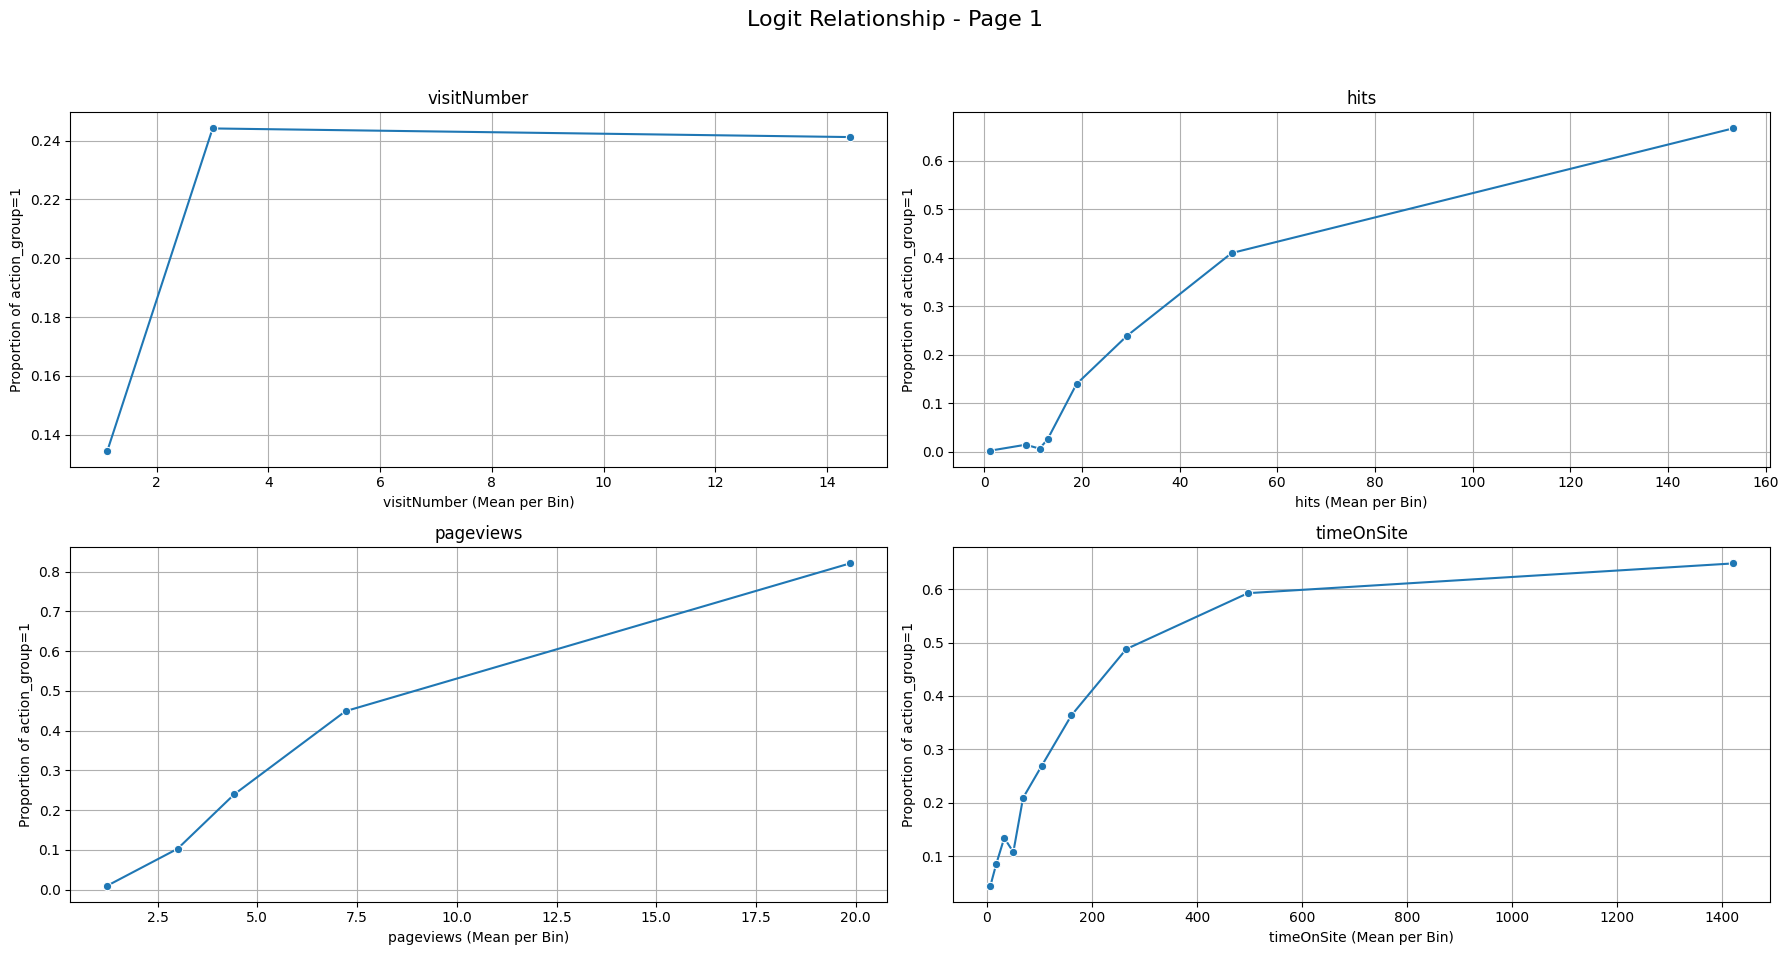

C:\Users\cysy0\AppData\Local\Temp\ipykernel_2352\1648858252.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = temp_df.groupby('bin').agg({
C:\Users\cysy0\AppData\Local\Temp\ipykernel_2352\1648858252.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df = temp_df.groupby('bin').agg({
C:\Users\cysy0\AppData\Local\Temp\ipykernel_2352\1648858252.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  plot_df

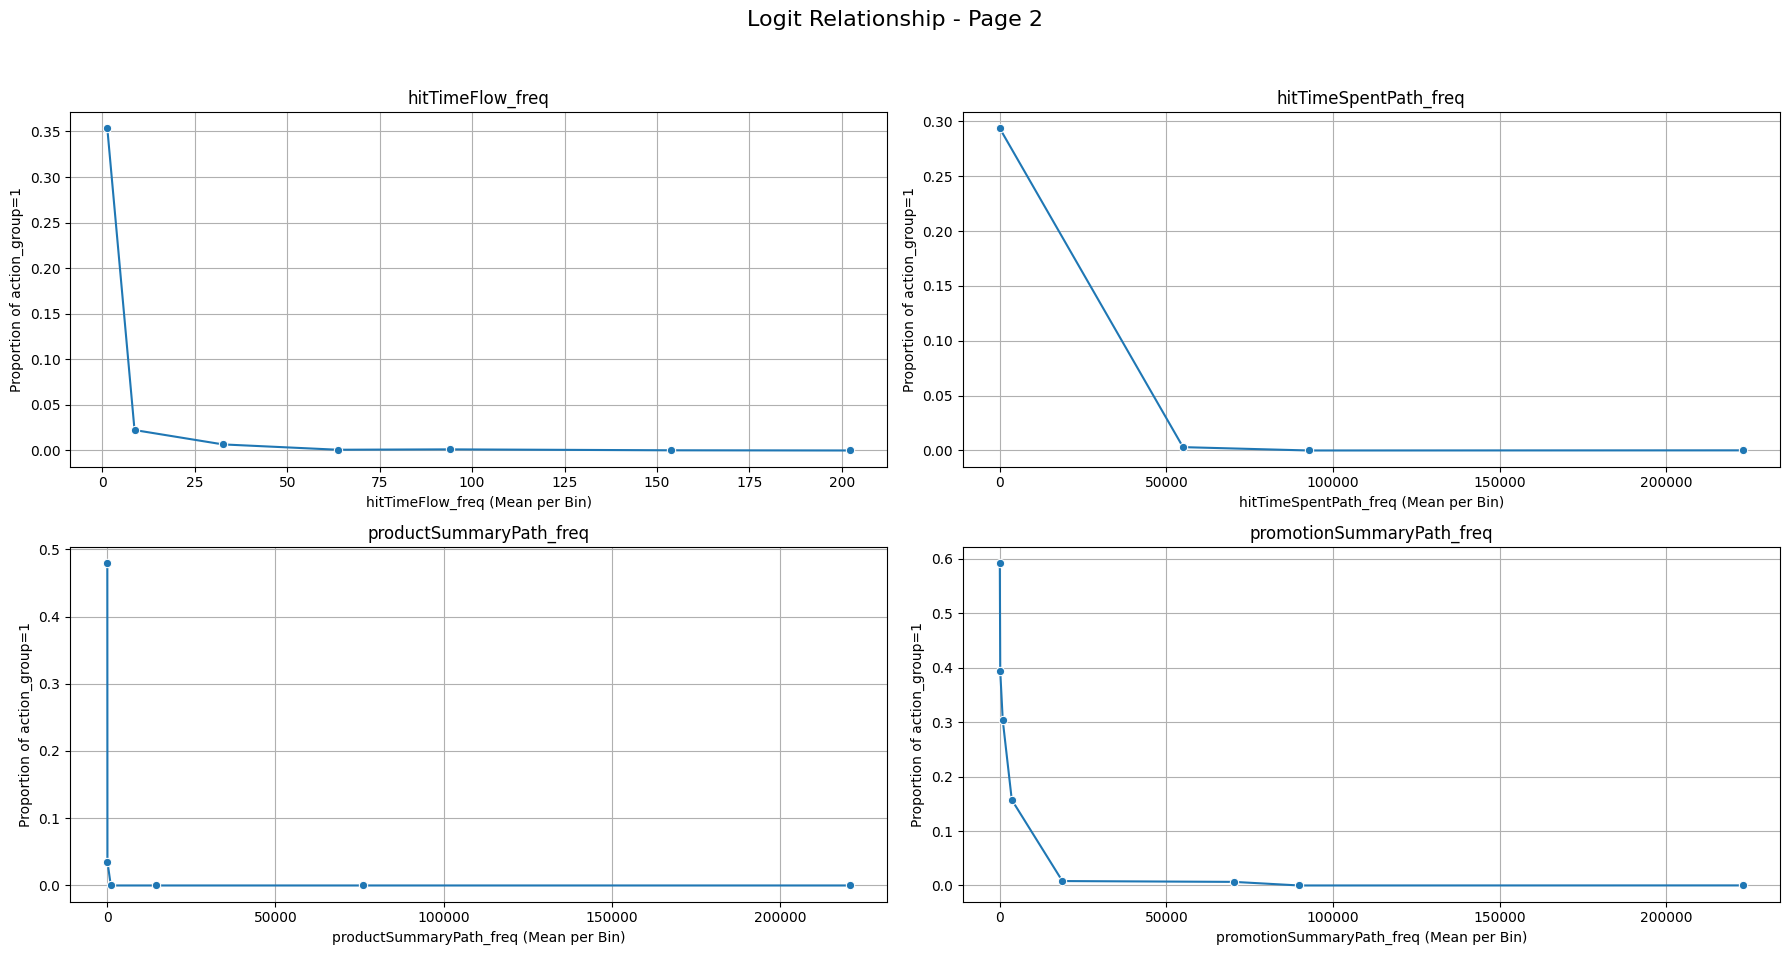

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

target = 'action_group'

# 기본 수치형 컬럼 (int64, float64) 중 타겟 제외
numeric_cols = sampled_df.select_dtypes(include=['int64', 'float64']).columns.drop(target).tolist()

# newVisits 명시적으로 제거
numeric_cols = [col for col in numeric_cols if col != 'newVisits']

# 한 페이지당 몇 개씩 보여줄지
cols_per_page = 4

# 전체 페이지 수 계산
num_pages = (len(numeric_cols) + cols_per_page - 1) // cols_per_page

for page in range(num_pages):
    start = page * cols_per_page
    end = start + cols_per_page
    current_cols = numeric_cols[start:end]

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
    axes = axes.flatten()

    for i, col in enumerate(current_cols):
        ax = axes[i]
        temp_df = sampled_df[[col, target]].copy().dropna()

        try:
            temp_df['bin'] = pd.qcut(temp_df[col], q=10, duplicates='drop')
        except ValueError:
            ax.set_title(f"{col} - Skipped (Low Uniqueness)")
            ax.axis('off')
            continue

        plot_df = temp_df.groupby('bin').agg({
            col: 'mean',
            target: 'mean'
        }).reset_index()

        sns.lineplot(data=plot_df, x=col, y=target, marker='o', ax=ax)
        ax.set_title(f'{col}')
        ax.set_xlabel(f'{col} (Mean per Bin)')
        ax.set_ylabel('Proportion of action_group=1')
        ax.grid(True)

    # 남은 subplot 비우기 (축 제거)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.suptitle(f'Logit Relationship - Page {page + 1}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



| 변수명                    | 시각적 패턴              | 선형성 판단      | 로그 변환 권장 여부 | 이유 |
|---------------------------|---------------------------|------------------|----------------------|------|
| **visitNumber**           | 급격한 상승 후 평탄       | ❌ 비선형     | ✅ 추천             | log 변환해도 큰 효과 없음, 해석상 명확 |
| **hits**                  | 명확한 우상향             | ✅ 선형성 양호     | ❌ 불필요             | 이미 선형 형태 만족 |
| **pageviews**             | 명확한 우상향             | ✅ 선형성 양호     | ❌ 불필요             | log 변환하면 선형성 감소할 수 있음 |
| **timeOnSite**            | 빠른 상승 후 정체         | ❌ 비선형          | ✅ 추천               | `log1p` 적용 시 선형성 강화, 해석 쉬워짐 |
| **hitTimeFlow_freq**      | 급감 후 평탄              | ❌ 명확한 비선형   | ✅ 강력 추천          | 분포 왜곡 큼 → `log1p`로 안정화 |
| **hitTimeSpentPath_freq** | 급감 후 평탄              | ❌ 명확한 비선형   | ✅ 강력 추천          | 위와 동일 |
| **productSummaryPath_freq** | 급감 후 평탄           | ❌ 명확한 비선형   | ✅ 강력 추천          | 위와 동일 |
| **promotionSummaryPath_freq** | 급감 후 평탄         | ❌ 명확한 비선형   | ✅ 강력 추천          | 위와 동일 |


> Box-Tidwell

- 통계적으로 연속 변수와 logit(p)의 선형 관계가 성립하는지를 확인

In [10]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: statsmodels in c:\users\cysy0\shap_env\lib\site-packages (0.14.4)



You should consider upgrading via the 'c:\Users\cysy0\shap_env\Scripts\python.exe -m pip install --upgrade pip' command.


c:\Users\cysy0\shap_env\lib\site-packages\statsmodels\genmod\families\links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


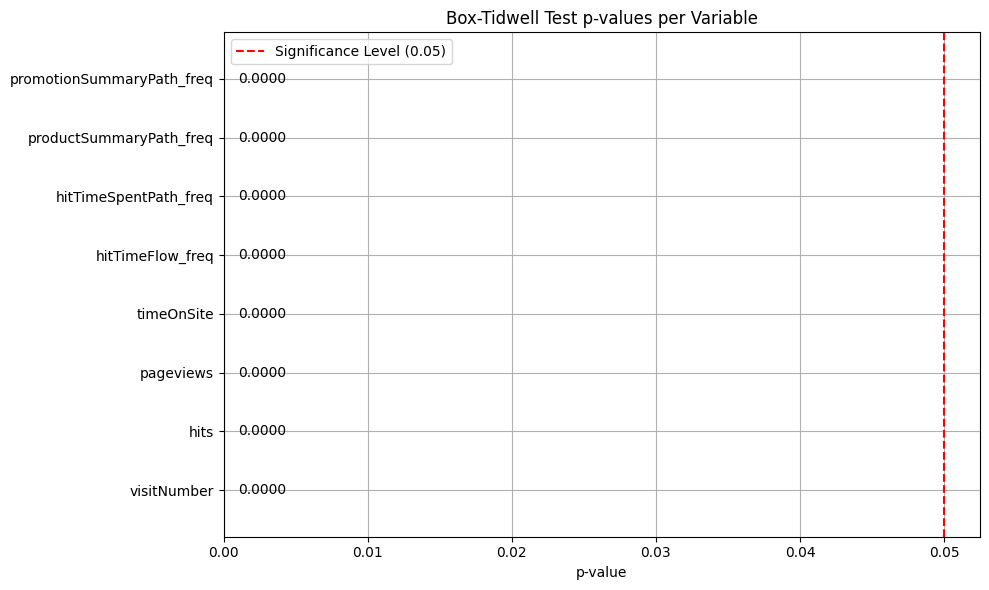

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Box-Tidwell 테스트용 함수
def box_tidwell_test(df, features, target):
    df = df.copy()
    df = df[features + [target]].dropna()

    p_values = {}
    for col in features:
        df[f'{col}_log'] = df[col] * np.log(df[col] + 1e-8)
        formula = f"{target} ~ {col} + {col}_log"
        model = glm(formula=formula, data=df, family=sm.families.Binomial()).fit()
        p = model.pvalues.get(f'{col}_log', np.nan)
        p_values[col] = p

    return p_values

# 분석 대상 변수 (8개)
features = [
    'visitNumber',
    'hits',
    'pageviews',
    'timeOnSite',
    'hitTimeFlow_freq',
    'hitTimeSpentPath_freq',
    'productSummaryPath_freq',
    'promotionSummaryPath_freq'
]

# 타겟 변수
target = 'action_group'

# 테스트 실행
pvals = box_tidwell_test(sampled_df, features, target)

# 시각화
plt.figure(figsize=(10, 6))
bars = plt.barh(list(pvals.keys()), list(pvals.values()), color='skyblue')

# p-value 수치 텍스트로 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', va='center', ha='left', fontsize=10)

# 기준선 및 기타 설정
plt.axvline(x=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('p-value')
plt.title('Box-Tidwell Test p-values per Variable')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


> 로그 변환 (Binning 시각화 기반)

In [12]:
log_transform_cols = [
    'visitNumber',
    'timeOnSite',
    'hitTimeFlow_freq',
    'hitTimeSpentPath_freq',
    'productSummaryPath_freq',
    'promotionSummaryPath_freq'
]

# 로그 변환 적용 (log1p는 log(x + 1), 0값 처리 안전)
for col in log_transform_cols:
    sampled_df[col] = np.log1p(sampled_df[col])

## 4.2 다중공선성 확인 

- VIF 지표로 독립변수 간 다중공선성 확인
- Bool 타입 변수들은 전처리 생성 과정에서 다중공선성 가능성 제거

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# 대상 변수 리스트 (bool 제외, 타겟 제외)
target = 'action_group'
X = sampled_df.select_dtypes(include=['int64', 'float64']).drop(columns=[target])

# 결측값 0으로 채우기
X = X.fillna(0)

# 표준화
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# VIF 계산
vif_df = pd.DataFrame()
vif_df["Variable"] = X_scaled.columns
vif_df["VIF"] = [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]

# 출력 (VIF 높은 순 정렬)
vif_df = vif_df.sort_values("VIF", ascending=False).reset_index(drop=True)
print(vif_df)

                    Variable        VIF
0           hitTimeFlow_freq  14.801989
1      hitTimeSpentPath_freq  12.730184
2                 timeOnSite   7.883146
3  promotionSummaryPath_freq   5.584802
4                  pageviews   4.940066
5                       hits   4.537635
6    productSummaryPath_freq   4.086779
7                  newVisits   2.232660
8                visitNumber   2.208496


> hitTimeFlow_freq, hitTimeSpentPath_freq

- 히트별 시작 시간과 히트별 체류 시간 정보를 나타내는 컬럼들로 하나의 컬럼으로 다른 컬럼의 데이터를 유추할 수 있다. 두 변수 모두 히트별 시간을 나타내고 있어 유사한 경로 흐름 정보를 담고 있어 둘 중 변수 해석이 용이하고 타겟을 예측하는데 영향을 준다고 판단되는 hitTimeSpentPath_freq를 선택하고 hitTimeFlow_freq는 제거한다.

> timeOnSite & promotionSummaryPath_freq

- 예측보다 변수별 해석이 목표이며 비즈니스적 의미가 있다고 판단되어 7.88, 5.5 정도의 VIF 지수는 허용한다.
- 사이트 체류 시간은 총 히트 수와 상관 관계를 가지지만 항상 비례하지 않으며(히트별 체류 시간 상이) 각 컬럼을 통해 해석 가능한 정보가 다르기에 그대로 사용한다. 

In [14]:
# 다중공선성으로 제거할 컬럼
sampled_df = sampled_df.drop(columns=['hitTimeFlow_freq'])

## 4.3 표준화 (StandardScaler)

> StandardScaler

- 로지스틱 회귀는 선형 모델이라 계수(변수 영향력 크기) 해석에 민감
- 평균 0, 표준편차 1로 맞춰 계수 크기를 비교해서 변수의 상대적 영향력 해석
- 계수 해석이 목적이므로 StandardScaler가 적절 

In [15]:
from sklearn.preprocessing import StandardScaler

# 선택된 feature 목록
selected_features = [
    'hitTimeSpentPath_freq',
    'timeOnSite',
    'promotionSummaryPath_freq',
    'pageviews',
    'hits',
    'productSummaryPath_freq',
    'newVisits',
    'visitNumber'
]

# feature와 타겟 분리
X = sampled_df[selected_features].copy()
y = sampled_df['action_group']

# 결측값 0으로 채우기
X = X.fillna(0)

# 표준화
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=selected_features)

## 4.4 로지스틱 회귀 모델 학습

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import pandas as pd
import numpy as np

# 1️⃣ 전체 독립변수 선택 (타겟 제외)
X_full = sampled_df.drop(columns=['action_group'])
y_full = sampled_df['action_group']

# 2️⃣ 결측값 처리 (예: 0으로 채우기)
X_full = X_full.fillna(0)

# 3️⃣ 로지스틱 회귀 학습
model_full = LogisticRegression(max_iter=1000, random_state=42)
model_full.fit(X_full, y_full)

LogisticRegression(max_iter=1000, random_state=42)

## 4.5 성능 평가


In [17]:
# 4️⃣ 성능 평가
y_pred = model_full.predict(X_full)
y_prob = model_full.predict_proba(X_full)[:, 1]

print("=== Confusion Matrix ===")
print(confusion_matrix(y_full, y_pred))

print("\n=== Classification Report ===")
print(classification_report(y_full, y_pred))

print(f"F1 Score: {f1_score(y_full, y_pred):.4f}")
print(f"AUPRC (Average Precision): {average_precision_score(y_full, y_prob):.4f}")

=== Confusion Matrix ===
[[83285  1966]
 [ 5067  9682]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     85251
           1       0.83      0.66      0.73     14749

    accuracy                           0.93    100000
   macro avg       0.89      0.82      0.85    100000
weighted avg       0.93      0.93      0.93    100000

F1 Score: 0.7336
AUPRC (Average Precision): 0.8506


> F1 Score: 0.7336, AUPRC: 0.8506

- 로지스틱 회귀 모델을 해석용으로 사용하기에 충분히 신뢰할 수 있는 수준에 성능으로 
 추가적인 튜닝 없이 해당 모델을 통해 계수(변수의 영향 정도)를 해석한다.

## 4.6 계수 해석 및 오즈비 계산 

In [18]:
# 5️⃣ 계수 및 오즈비
coef_df = pd.DataFrame({
    'Feature': X_full.columns,
    'Coefficient': model_full.coef_[0]
})
coef_df['Odds Ratio'] = np.exp(coef_df['Coefficient'])
coef_df['|Coef|'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('|Coef|', ascending=False).drop(columns='|Coef|')

print("\n=== Coefficients & Odds Ratios ===")
print(coef_df)


=== Coefficients & Odds Ratios ===
                       Feature  Coefficient  Odds Ratio
40           year_month_201611    -1.622740    0.197357
44           year_month_201703    -1.604375    0.201015
41           year_month_201612    -1.552703    0.211675
43           year_month_201702    -1.549865    0.212277
39           year_month_201610    -1.548997    0.212461
..                         ...          ...         ...
108      country_United States     0.002904    1.002909
23          socialNetwork_Digg     0.000000    1.000000
27   socialNetwork_Hacker News     0.000000    1.000000
29        socialNetwork_Meetup     0.000000    1.000000
33        socialNetwork_Tumblr     0.000000    1.000000

[125 rows x 3 columns]


In [ ]:
# 전체 컬럼 계수 확인
from IPython.display import display
display(coef_df)

> 계수 기준 영향 방향별 상위 5개 변수 추출

- 양의 영향 변수 공통점: 특정 시기, 채널, 지역, 탐색량이 전환에 긍정적 영향
- 음의 영향 변수 공통점: 혼란스러운 경로 또는 명확하지 않은/효율적이지 않은 유입은 이탈을 유도

In [19]:
# 계수 기준 정렬
top_positive = coef_df[coef_df['Coefficient'] > 0].sort_values(by='Coefficient', ascending=False).head(5)
top_negative = coef_df[coef_df['Coefficient'] < 0].sort_values(by='Coefficient', ascending=True).head(5)

print("🔵 상위 5개 양의 영향 변수 (계수 기준)")
print(top_positive)

print("\n🔴 상위 5개 음의 영향 변수 (계수 기준)")
print(top_negative)

🔵 상위 5개 양의 영향 변수 (계수 기준)
                   Feature  Coefficient  Odds Ratio
34   socialNetwork_Twitter     0.902367    2.465433
109        country_Vietnam     0.635293    1.887576
83        city_Los Angeles     0.536324    1.709710
86      city_San Francisco     0.486405    1.626459
2                pageviews     0.474962    1.607953

🔴 상위 5개 음의 영향 변수 (계수 기준)
              Feature  Coefficient  Odds Ratio
40  year_month_201611    -1.622740    0.197357
44  year_month_201703    -1.604375    0.201015
41  year_month_201612    -1.552703    0.211675
43  year_month_201702    -1.549865    0.212277
39  year_month_201610    -1.548997    0.212461


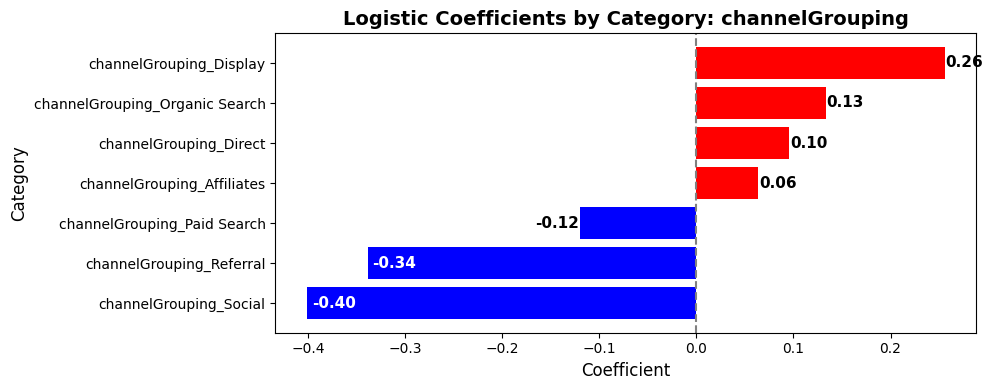

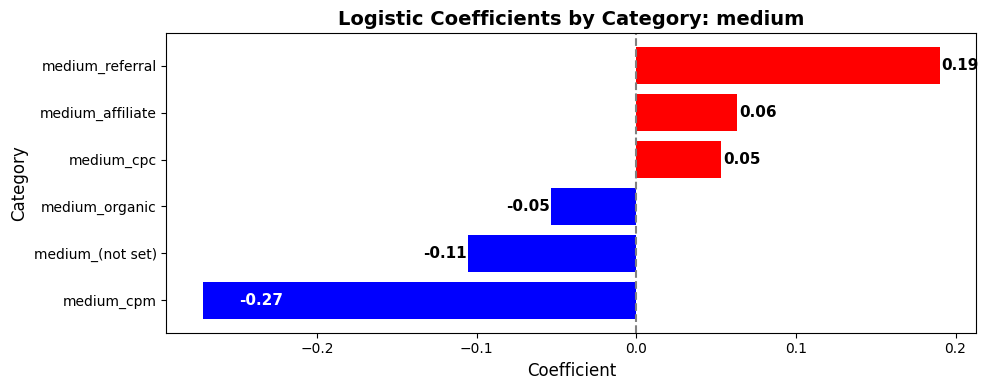

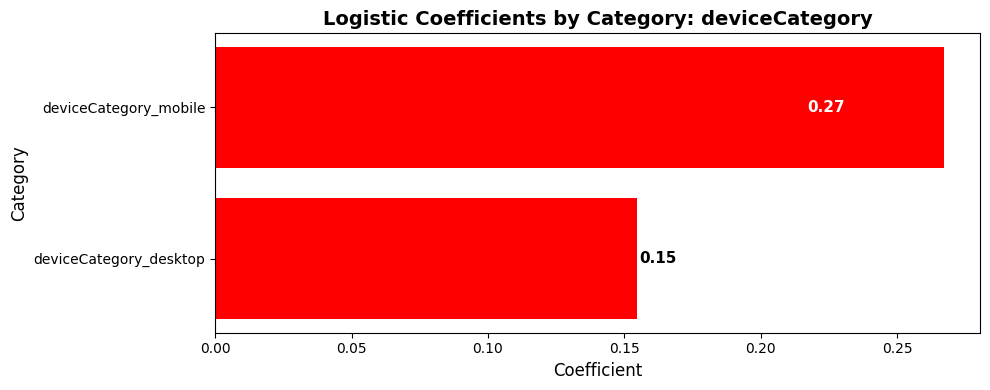

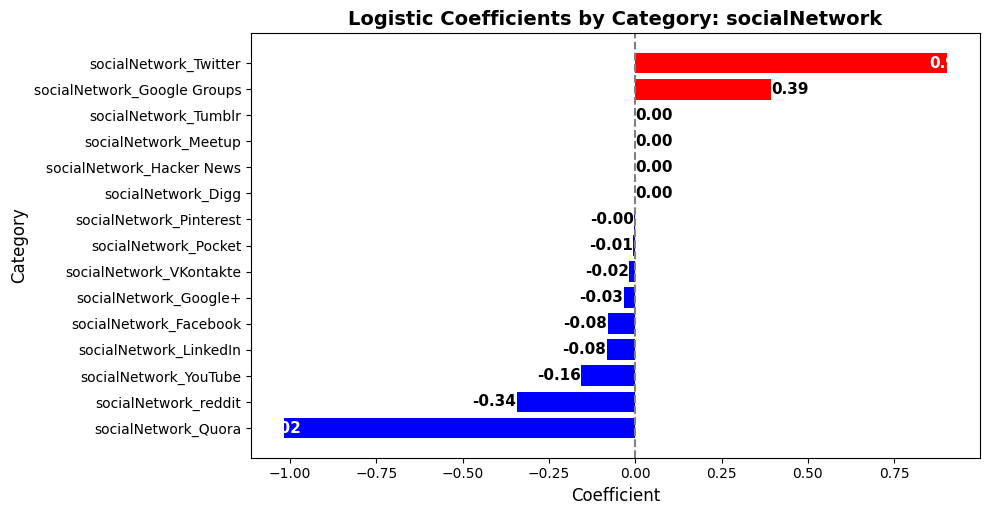

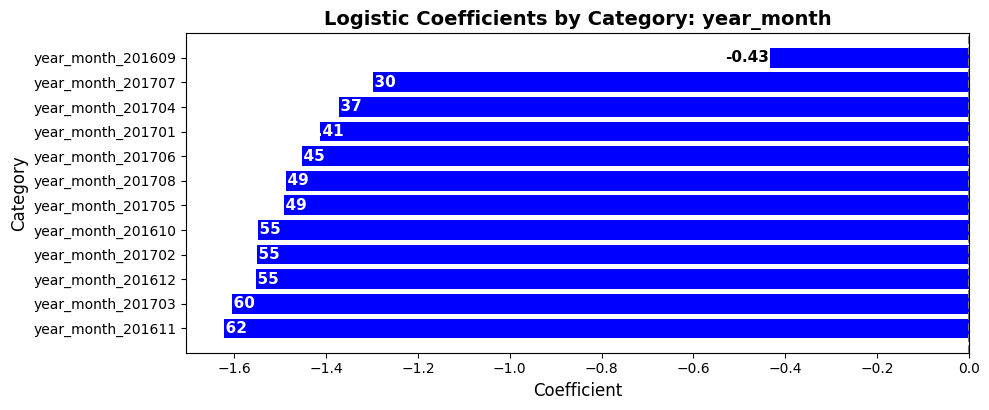

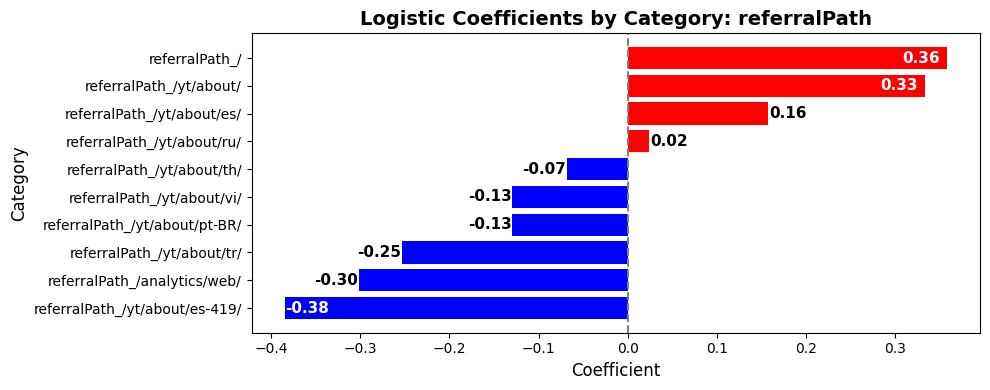

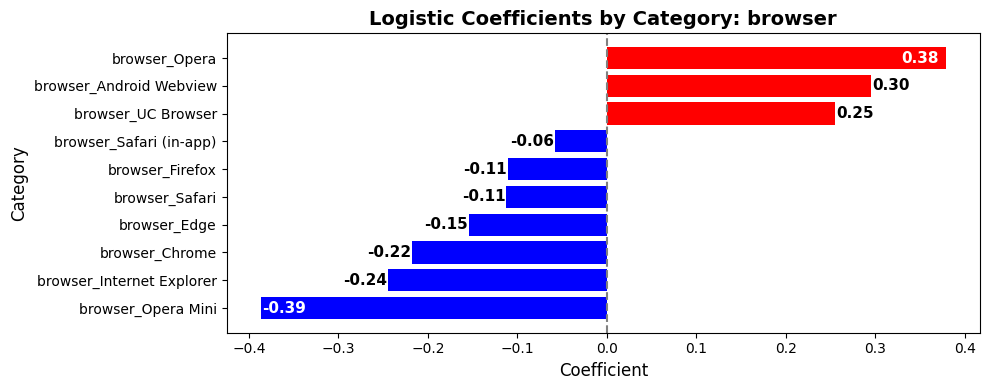

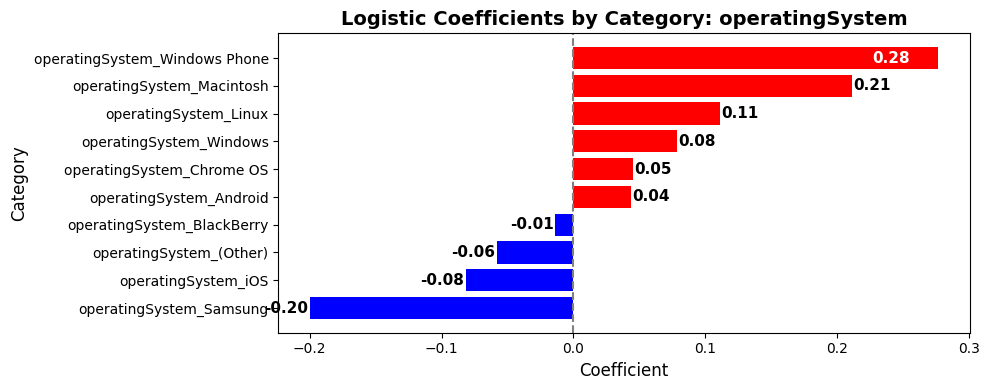

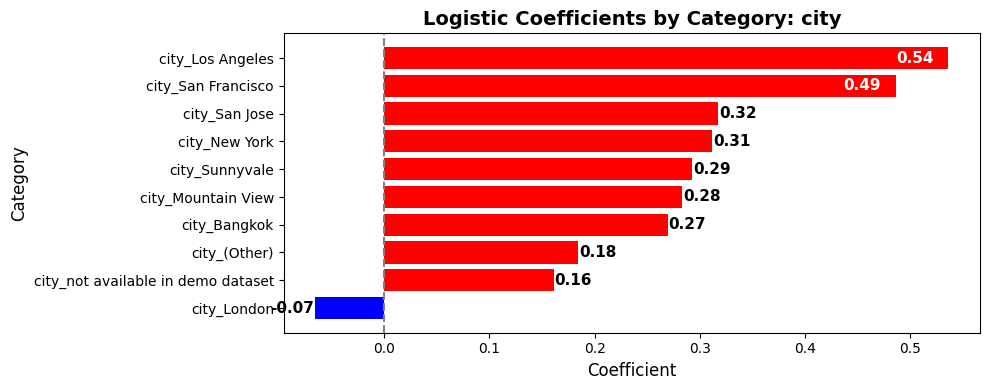

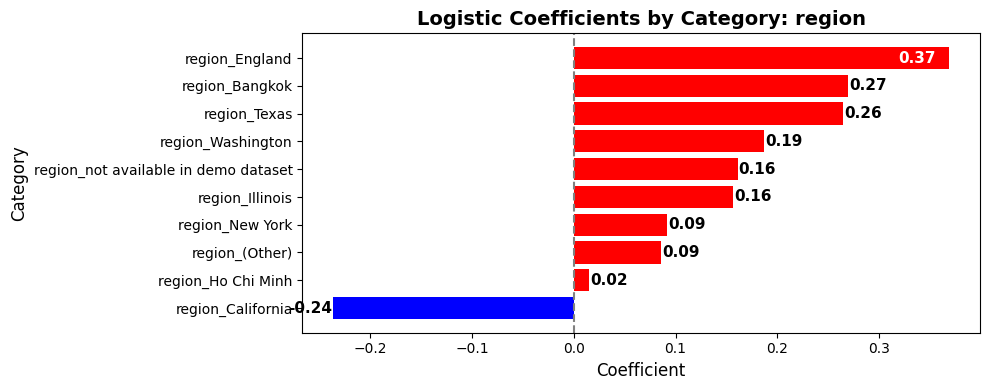

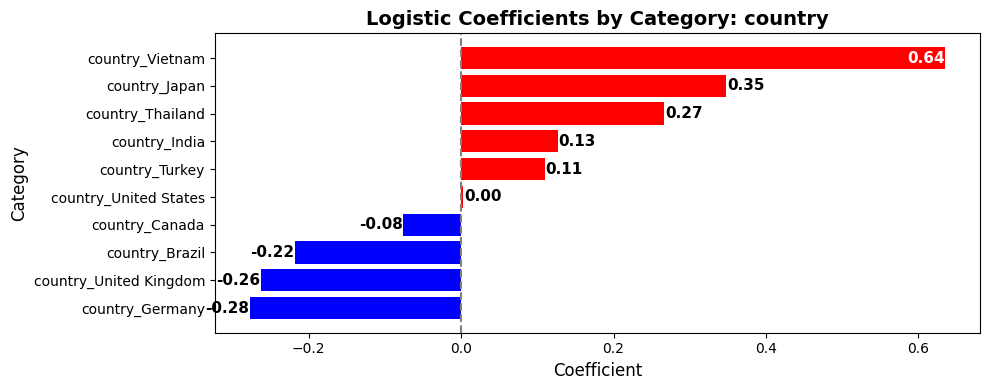

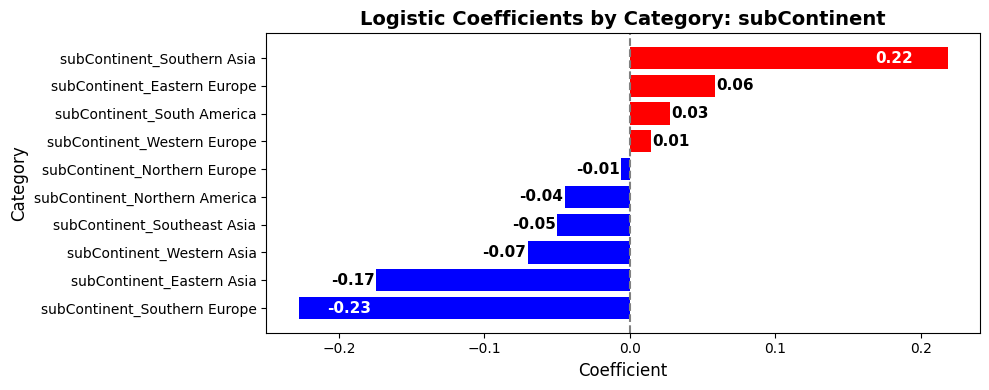

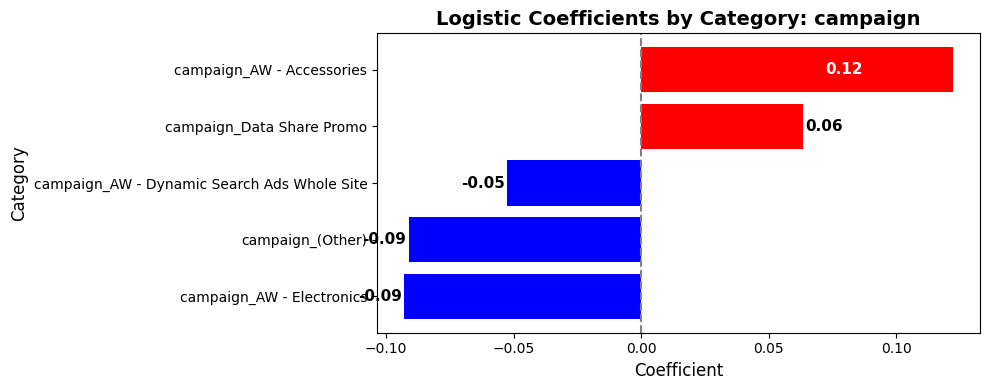

In [20]:
import matplotlib.pyplot as plt

# 범주형 변수 리스트
categorical_vars = [
    'channelGrouping', 'medium', 'deviceCategory', 'socialNetwork', 'year_month',
    'referralPath', 'browser', 'operatingSystem', 'city', 'region',
    'country', 'subContinent', 'campaign'
]

for var in categorical_vars:
    var_features = coef_df[coef_df['Feature'].str.startswith(var + '_')].copy()
    if var_features.empty:
        continue

    var_features = var_features.sort_values('Coefficient', ascending=True)
    colors = ['red' if x > 0 else 'blue' for x in var_features['Coefficient']]

    plt.figure(figsize=(10, max(4, len(var_features) * 0.35)))
    bars = plt.barh(var_features['Feature'], var_features['Coefficient'], color=colors)
    
    max_width = max(abs(var_features['Coefficient'].max()), abs(var_features['Coefficient'].min()))
    
    for bar in bars:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        text = f'{width:.2f}'
        font_color = 'white' if abs(width) > max_width * 0.8 else 'black'
        ha_pos = 'right' if width < 0 else 'left'

        # 텍스트 위치: 막대가 길면 안쪽에, 아니면 바깥쪽에
        if abs(width) > max_width * 0.8:
            x_pos = width - 0.05 if width > 0 else width + 0.05
        else:
            x_pos = width + 0.001 if width > 0 else width - 0.001

        plt.text(
            x_pos, y_pos, text,
            va='center', ha=ha_pos,
            fontsize=11, fontweight='bold', color=font_color
        )

    plt.axvline(0, color='gray', linestyle='--')
    plt.title(f'Logistic Coefficients by Category: {var}', fontsize=14, fontweight='bold')
    plt.xlabel('Coefficient', fontsize=12)
    plt.ylabel('Category', fontsize=12)
    plt.tight_layout()
    plt.show()


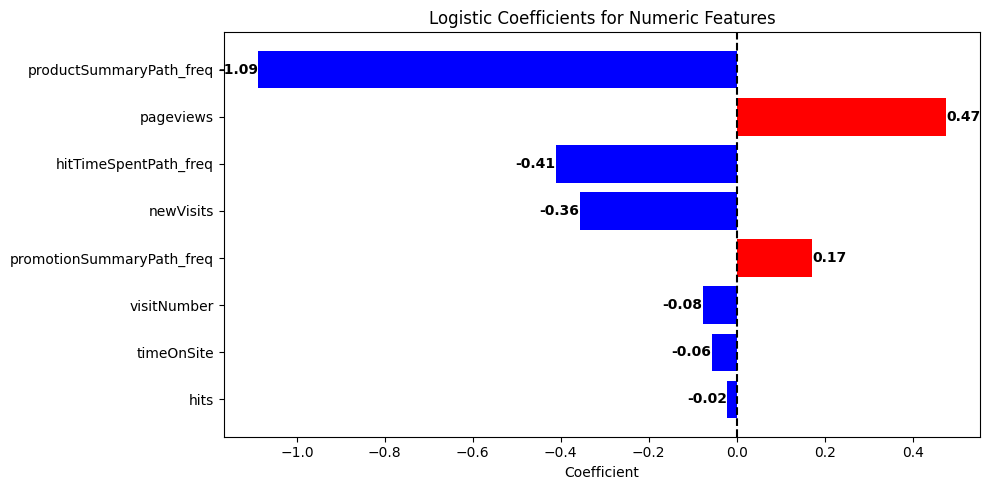

In [21]:
import matplotlib.pyplot as plt

# 1️⃣ 수치형 변수 리스트 지정 (인코딩 전 변수명 기준)
numeric_vars = [
    'visitNumber', 'hits', 'pageviews', 'timeOnSite', 'newVisits',
    'hitTimeFlow_freq', 'hitTimeSpentPath_freq', 'productSummaryPath_freq', 'promotionSummaryPath_freq'
]

# 2️⃣ coef_df에서 해당 변수만 필터링
numeric_coef_df = coef_df[coef_df['Feature'].isin(numeric_vars)].copy()

# 정렬 (절댓값 기준)
numeric_coef_df['abs_coef'] = numeric_coef_df['Coefficient'].abs()
numeric_coef_df = numeric_coef_df.sort_values('abs_coef', ascending=False)

# 3️⃣ 색상 설정
colors = numeric_coef_df['Coefficient'].apply(lambda x: 'red' if x > 0 else 'blue')

# 4️⃣ 시각화
plt.figure(figsize=(10, 5))
bars = plt.barh(numeric_coef_df['Feature'], numeric_coef_df['Coefficient'], color=colors)

# 텍스트 라벨 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001 if width > 0 else width - 0.001,
             bar.get_y() + bar.get_height()/2,
             f"{width:.2f}",
             va='center',
             ha='left' if width > 0 else 'right',
             fontsize=10,
             fontweight='bold')

plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel("Coefficient")
plt.title("Logistic Coefficients for Numeric Features")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


> 계수 시각화 변수 해석 예시

- 양의 방향인 컬럼에 해당하는 사용자는 음의 방향인 컬럼에 사용자보다 다음 단계로 진행하는 경향을 보인다. 

# 5. LightBGM

## 5.0 기본 모델 학습

In [22]:
from sklearn.model_selection import train_test_split

# 타겟 및 입력 변수 설정
target = 'action_group'
X = sampled_df.drop(columns=[target])
y = sampled_df[target]

# 학습/검증 분할 (stratify 적용)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [23]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, average_precision_score

# 모델 정의
lgbm_model = LGBMClassifier(random_state=42)

# 학습
lgbm_model.fit(X_train, y_train)

# 예측
y_pred = lgbm_model.predict(X_val)
y_prob = lgbm_model.predict_proba(X_val)[:, 1]  # AUPRC용 확률

# 성능 평가
f1 = f1_score(y_val, y_pred)
auprc = average_precision_score(y_val, y_prob)

print("✅ LightGBM 기본 모델 학습 완료")
print(f"F1 Score: {f1:.4f}")
print(f"AUPRC (Average Precision): {auprc:.4f}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11799, number of negative: 68201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147487 -> initscore=-1.754444
[LightGBM] [Info] Start training from score -1.754444
✅ LightGBM 기본 모델 학습 완료
F1 Score: 0.8088
AUPRC (Average Precision): 0.8980


## 5.1 과적합 여부 확인

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11799, number of negative: 68201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 113
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147487 -> initscore=-1.754444
[LightGBM] [Info] Start training from score -1.754444


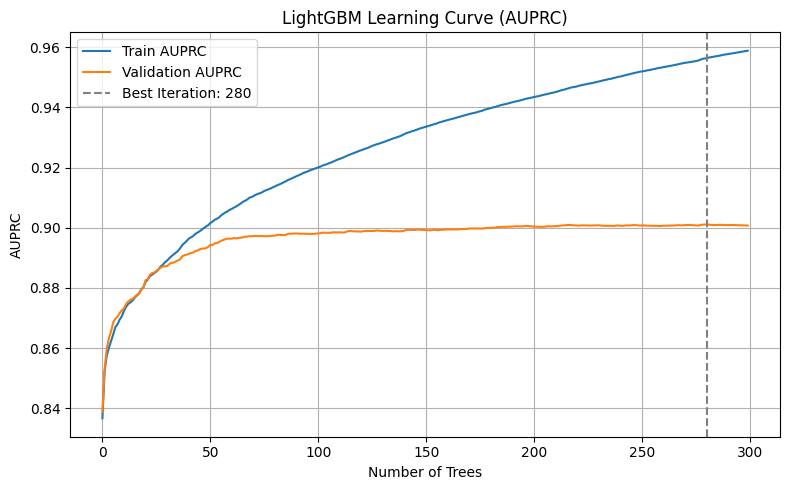

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score

# LightGBM 모델 정의
model = LGBMClassifier(n_estimators=300, random_state=42)

# 학습 (verbose 제거)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric='average_precision'
)

# 결과 저장
train_scores = model.evals_result_['training']['average_precision']
val_scores = model.evals_result_['valid_1']['average_precision']

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_scores, label='Train AUPRC')
plt.plot(val_scores, label='Validation AUPRC')
plt.axvline(np.argmax(val_scores), color='gray', linestyle='--', label=f"Best Iteration: {np.argmax(val_scores)}")
plt.title('LightGBM Learning Curve (AUPRC)')
plt.xlabel('Number of Trees')
plt.ylabel('AUPRC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


> 과적합 여부 확인

- 두 지표 간 격차가 크지만, Validation 성능이 일정 수준 이상에서 안정적으로 유지되므로 심한 과적합은 아니며, 일반화 성능이 잘 유지되는 학습 패턴으로 보임.

> 최적 트리 수 결정 근거

- 280번째 트리에서 Validation AUPRC가 최고점 도달하며 이후 트리수를 늘려도 증가하지 않거나 미세하게 감소하여 해당 트리 수에서 과적합을 방지하고 최적의 성능을 낸다고 해석

## 5.2 최적 피처 조합 (SHAP 기반)

In [ ]:
# 터미널 실행
pip uninstall shap numpy -y
pip install numpy==1.21.4
pip install shap==0.41.0

In [25]:
import shap
import numpy as np

print("numpy:", np.__version__)
print("shap:", shap.__version__)


c:\Users\cysy0\shap_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy: 1.23.5
shap: 0.41.0


In [26]:
import shap
import numpy as np
import pandas as pd
from collections import Counter

# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)  # 클래스별 SHAP: list of arrays

# y_train에서 클래스 비율 계산 (0, 1 두 클래스 가정)
class_counts = Counter(y_train)
total = sum(class_counts.values())
class_weights = [class_counts[i] / total for i in range(len(shap_values))]  # [비율_0, 비율_1]

# 클래스별 SHAP 값을 가중 평균
shap_vals_weighted = np.average(shap_values, axis=0, weights=class_weights)  # (n_samples, n_features)

# 피처별 평균 절대 SHAP 중요도 계산
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': np.abs(shap_vals_weighted).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

# 상위 10개 출력
print(shap_importance.head(10))


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


                     feature  mean_abs_shap
0    productSummaryPath_freq       2.803224
1                  pageviews       0.556703
2      hitTimeSpentPath_freq       0.514129
3                       hits       0.250222
4                 timeOnSite       0.223477
5  promotionSummaryPath_freq       0.155391
6          year_month_201611       0.081801
7                visitNumber       0.059067
8          year_month_201612       0.044047
9          year_month_201610       0.039177


> SHAP 평균 절댓값
- 같은 컬럼이라도 학습 때마다 예측에 영향을 주는 정도가 달라서 모든 예측에서의 평균 기여도를 확인하기 위해 평균 절댓값 확인

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11799, number of negative: 68201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1399
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 113
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147487 -> initscore=-1.754444
[LightGBM] [Info] Start training from score -1.754444
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 11799, number of negative: 68201
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_

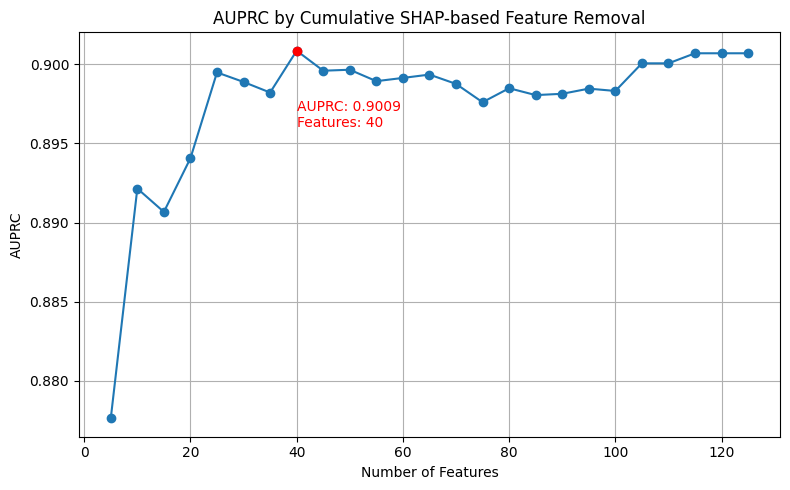

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd

# 평균 절댓값 기준 중요도 정렬 (오름차순: 낮은 중요도부터 제거)
shap_importance = pd.DataFrame({
    'feature': X_train.columns,
    'mean_abs_shap': np.abs(shap_vals_weighted).mean(axis=0)
}).sort_values(by='mean_abs_shap', ascending=True).reset_index(drop=True)

# AUPRC 기록용 리스트
auprc_list = []
feature_counts = []

# 전체 피처 수
total_features = len(shap_importance)

# 반복 제거 및 평가
for i in range(0, total_features, 5):
    selected_features = shap_importance['feature'][i:].tolist()

    model = LGBMClassifier(n_estimators=300, random_state=42)
    model.fit(X_train[selected_features], y_train)

    preds = model.predict_proba(X_val[selected_features])[:, 1]
    auprc = average_precision_score(y_val, preds)

    auprc_list.append(auprc)
    feature_counts.append(len(selected_features))

# 최적값 찾기
best_idx = np.argmax(auprc_list)
best_feature_count = feature_counts[best_idx]
best_auprc = auprc_list[best_idx]

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(feature_counts, auprc_list, marker='o')
plt.scatter(best_feature_count, best_auprc, color='red', zorder=5)  # 최적점 강조
plt.text(best_feature_count, best_auprc - 0.005, 
         f'AUPRC: {best_auprc:.4f}\nFeatures: {best_feature_count}', 
         fontsize=10, ha='left', va='bottom', color='red')

plt.xlabel("Number of Features")
plt.ylabel("AUPRC")
plt.title("AUPRC by Cumulative SHAP-based Feature Removal")
plt.grid(True)
plt.tight_layout()
plt.show()
 

In [ ]:
from sklearn.metrics import f1_score, average_precision_score

# 1. 최적 피처 조합 선택
optimal_features = shap_importance['feature'][total_features - best_feature_count:].tolist()

# 2. 모델 학습
final_model = LGBMClassifier(n_estimators=300,   class_weight='balanced',random_state=42)
final_model.fit(X_train[optimal_features], y_train)

# 3. 예측 및 평가
preds_bin = final_model.predict(X_val[optimal_features])  # 이진 예측
preds_proba = final_model.predict_proba(X_val[optimal_features])[:, 1]  # 확률 예측

f1 = f1_score(y_val, preds_bin)
auprc = average_precision_score(y_val, preds_proba)

# 4. 결과 출력
print("✅ 최적 피처 조합 기준 성능")
print(f"  - Feature 개수: {best_feature_count}")
print(f"  - F1 Score     : {f1:.5f}")
print(f"  - AUPRC        : {auprc:.5f}")


In [ ]:
# 중요도 높은 순으로 정렬된 전체 피처 리스트
sorted_features = shap_importance.sort_values(by='mean_abs_shap', ascending=False)

# 최적 피처 조합 (상위 40개)
top_40_features = sorted_features.head(40)

# 그 중 상위 5개 피처 출력
print("💡 AUPRC 기준 최적 피처 조합(40개) 중 상위 5개 변수:")
print(top_40_features.head(5))


## 5.3 최적 하이퍼파라미터

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, average_precision_score
from lightgbm import LGBMClassifier
import numpy as np

# 1. 사용할 피처: SHAP 기반 상위 40개
top_40_features = shap_importance['feature'][total_features - best_feature_count:].tolist()
X_train_sel = X_train[top_40_features]
X_val_sel = X_val[top_40_features]

# 2. 파라미터 후보 정의
param_dist = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10, 20],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'min_child_samples': [10, 20, 50],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# 3. 모델 + 랜덤서치 정의
model = LGBMClassifier(n_estimators=300,  class_weight='balanced',random_state=42)
rand_search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=30,  # 조합 수 (조절 가능)
    scoring='average_precision',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 4. 탐색 실행
rand_search.fit(X_train_sel, y_train)

# 5. 최적 모델로 예측 및 평가
best_model = rand_search.best_estimator_
preds = best_model.predict(X_val_sel)
pred_probs = best_model.predict_proba(X_val_sel)[:, 1]

f1 = f1_score(y_val, preds)
auprc = average_precision_score(y_val, pred_probs)

# 최적 하이퍼파라미터 출력
print("✅ 최적 하이퍼파라미터:")
for param, value in rand_search.best_params_.items():
    print(f"  - {param}: {value}")

# 성능 지표 출력
print("\n✅ 검증 데이터 기준 성능:")
print(f"  - F1 Score: {f1:.5f}")
print(f"  - AUPRC   : {auprc:.5f}")

## 5.4 최적 THRESHOLD

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

# 1. 확률 예측
y_proba = best_model.predict_proba(X_val_sel)[:, 1]

# 2. 다양한 임계값에서 F1 Score 계산
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for thresh in thresholds:
    preds_bin = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_val, preds_bin)
    f1_scores.append(f1)

# 3. 최적 임계값
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# 4. 최적 임계값에서 AUPRC 계산
final_preds_bin = (y_proba >= best_thresh).astype(int)
auprc = average_precision_score(y_val, y_proba)

# 5. 시각화
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=best_thresh, color='red', linestyle='--', label=f"Best Threshold = {best_thresh:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score by Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 6. 결과 출력
print("✅ 최적 임계값 기준 성능")
print(f"  - Threshold : {best_thresh:.2f}")
print(f"  - F1 Score  : {best_f1:.5f}")
print(f"  - AUPRC     : {auprc:.5f}")


# 6. 주요 변수 해석 (SHAP 기반)

## 6.1 SHAP Feature Importance - 피처의 평균적 영향력

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. TreeExplainer로 전체 SHAP 값 계산
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sel)

# 2. 전체 기준 SHAP 영향도 (클래스별 반환이면 평균 사용)
# 다중 반환인 경우: list → 클래스별 → np.abs 후 평균
if isinstance(shap_values, list):
    shap_values_combined = np.mean([np.abs(sv) for sv in shap_values], axis=0)
else:
    shap_values_combined = np.abs(shap_values)

# 3. 평균 절대값 기준 정리
mean_abs_shap = shap_values_combined.mean(axis=0)
shap_summary = pd.DataFrame({
    'feature': X_val_sel.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False).reset_index(drop=True)

# 4. 상위 10개 추출
top10 = shap_summary.head(10)

# 5. 시각화 (수평 바 차트)
plt.figure(figsize=(8, 6))
plt.barh(top10['feature'][::-1], top10['mean_abs_shap'][::-1])  # 역순으로 그려야 위에서 가장 영향 큰 것부터
for i, (value, feature) in enumerate(zip(top10['mean_abs_shap'][::-1], top10['feature'][::-1])):
    plt.text(value + 0.001, i, f"{value:.4f}", va='center', fontsize=9, color='black')

plt.xlabel('Mean |SHAP Value|')
plt.title('Top 10 Important Features (Overall SHAP)')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
# X_val 기준으로 다시 계산
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_val_sel)

# 클래스 비율 구하기 (y_val 기반)
from collections import Counter
class_counts = Counter(y_val)
total = sum(class_counts.values())
weights = [class_counts[i] / total for i in range(len(shap_values))]

# 클래스별 SHAP 값 가중 평균
shap_vals_weighted_val = np.average(shap_values, axis=0, weights=weights)

# summary plot 그리기
shap.summary_plot(shap_vals_weighted_val, X_val_sel, plot_type="bar")

In [ ]:
print(type(shap_values))         # list인가 array인가?
print(len(shap_values))          # 2여야 함 (class 0, 1)
print(shap_values[0].shape)      # 샘플 수, 피처 수 확인
print(np.all(shap_values[0] == shap_values[1]))  # 진짜 같은 값인지 비교

In [ ]:
import pandas as pd
import numpy as np

# 클래스 0, 1 각각에 대한 SHAP 값
shap_vals_class_0 = shap_values[0]  # class 0
shap_vals_class_1 = shap_values[1]  # class 1

# 절대값 기준 평균 영향력 계산
mean_0 = np.abs(shap_vals_class_0).mean(axis=0)
mean_1 = np.abs(shap_vals_class_1).mean(axis=0)

# 비교 테이블 생성
impact_df = pd.DataFrame({
    'feature': X_val_sel.columns,
    'class_0_mean_abs_shap': mean_0,
    'class_1_mean_abs_shap': mean_1,
    'difference (1 - 0)': mean_1 - mean_0
}).sort_values(by='difference (1 - 0)', ascending=False)

impact_df


## 6.2 클래스별 평균 shap 값 비교

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 클래스별 SHAP 값 중요도 시각화 함수 정의
def plot_top_shap_features(shap_values_class, X, class_label, top_n=10):
    # 평균 절댓값 기준 중요도 계산
    mean_abs_shap = np.abs(shap_values_class).mean(axis=0)
    feature_names = X.columns

    # 상위 N개 피처 추출
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False).head(top_n)

    # 시각화
    plt.figure(figsize=(8, 6))
    bars = plt.barh(shap_df['Feature'][::-1], shap_df['MeanAbsSHAP'][::-1], color='steelblue')

    # 각 바 끝에 SHAP 값 텍스트로 표기
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                 f"{width:.4f}", va='center', fontsize=9)

    plt.title(f"Top {top_n} Important Features (Class {class_label} SHAP)")
    plt.xlabel("Mean |SHAP Value|")
    plt.tight_layout()
    plt.show()

# 클래스별 시각화 실행
plot_top_shap_features(shap_values[0], X_val_sel, class_label=0)
plot_top_shap_features(shap_values[1], X_val_sel, class_label=1)


In [ ]:
import numpy as np
import pandas as pd

# 클래스별 평균 SHAP 값 계산
mean_0 = np.abs(shap_values[0]).mean(axis=0)
mean_1 = np.abs(shap_values[1]).mean(axis=0)
delta = mean_1 - mean_0

# 비교 테이블 생성
shap_diff_df = pd.DataFrame({
    'feature': X_val_sel.columns,
    'class_0': mean_0,
    'class_1': mean_1,
    'class1_minus_class0': delta
}).sort_values(by='class1_minus_class0', ascending=False)

# 상위 차이 출력
print(shap_diff_df.head(10))


In [ ]:
# 클래스별 SHAP 상위 10개 피처 이름 비교
top10_class_0 = np.abs(shap_values[0]).mean(axis=0)
top10_class_1 = np.abs(shap_values[1]).mean(axis=0)

df_compare = pd.DataFrame({
    "feature": X_val_sel.columns,
    "class_0_mean_abs_shap": top10_class_0,
    "class_1_mean_abs_shap": top10_class_1
}).sort_values(by="class_1_mean_abs_shap", ascending=False)

df_compare.head(10)


## 6.3 개별 피처 중심 예측 작용 시각화 

In [ ]:
shap.dependence_plot("feature_name", shap_vals_class_1, X_val_sel)